In [7]:
import torch
import torch.nn as nn
import fairseq
from d2l import torch as d2l

DEBUG:matplotlib:matplotlib data path: /home/felix/miniconda3/envs/Aopp/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/felix/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'contextlib', 'importlib.util', 'importlib.machinery', 'mpl_toolkits', 'site', 'runpy', '

In [8]:
cp_path = '/home/felix/Aopp/wav2vec_large.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
# model.eval()

DEBUG:hydra.core.utils:Setting JobRuntime:name=UNKNOWN_NAME
DEBUG:hydra.core.utils:Setting JobRuntime:name=utils
DEBUG:hydra.core.utils:Setting JobRuntime:name=utils
INFO:fairseq.models.wav2vec.wav2vec:Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2-4): 3 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (5-6): 2 x Se

In [9]:
# dense_size = model.feature_extractor.conv_layers[-1][0].out_channels
dense_size = 512
num_lables = 10
print('dense_size', dense_size)

dense_size 512


In [11]:
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec downstream task."""

    def __init__(self, dense_size, dropout_rate, num_labels):
        super().__init__()
        self.dense = nn.Linear(dense_size, dense_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.out_proj = nn.Linear(dense_size, num_labels)

    def forward(self, features):
        features = torch.mean(features, dim=-1)
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


In [15]:
net = nn.Sequential(model.feature_extractor, Wav2Vec2ClassificationHead(dense_size, 0.05, num_lables))

In [16]:
def train_net(net, train_iter, test_iter, num_epochs, lr1, lr2, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net[1].apply(init_weights)

    print('training on', device)
    net.to(device)

    params_to_optimize = [
        {"params": net[0].parameters(), "lr": lr1},
        {"params": net[1].parameters(), "lr": lr2},
    ]

    optimizer = torch.optim.SGD(params_to_optimize)

    loss = nn.CrossEntropyLoss()

    num_batches = len(train_iter)

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.588, train acc 0.771, test acc 0.804
325.8 examples/sec on cuda:0


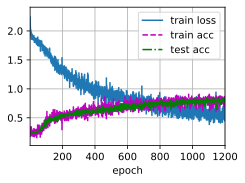

In [17]:
train_net(net, train_iter, test_iter, 1200, 0, 0.1, d2l.try_gpu())

In [ ]:
torch.save(net, './save.pt')

In [ ]:
net = torch.load('./save.pt')

In [ ]:
def train_net_conti(net, train_iter, test_iter, num_epochs, lr1, lr2, device):
    # def init_weights(m):
    #     if type(m) == nn.Linear or type(m) == nn.Conv2d:
    #         nn.init.xavier_uniform_(m.weight)

    # net[1].apply(init_weights)

    print('training on', device)
    net.to(device)

    params_to_optimize = [
        {"params": net[0].parameters(), "lr": lr1},
        {"params": net[1].parameters(), "lr": lr2},
    ]

    optimizer = torch.optim.SGD(params_to_optimize)

    loss = nn.CrossEntropyLoss()

    num_batches = len(train_iter)

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
train_net_conti(net, train_iter, test_iter, 800, 0, 0.1, d2l.try_gpu())

In [1]:
import torchaudio
import tqdm
import os
import torch
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils import data

In [2]:
temp_list = []
lable_dic = {"W": 'anger', "L": 'boredom', "E": 'disgust', "A": 'anxiety/fear', "F": 'happiness', "T": 'sadness', "N": 'neutral version'}

directory = "/home/felix/Aopp/0.0/EmoDB/wav"

for filename in os.listdir(directory):

    label = lable_dic[filename[5]]
    try:
        s = torchaudio.load(os.path.join(directory,filename))
        temp_list.append({
            "name": filename.split('.')[0],
            "path": os.path.join(directory,filename),
            "emotion": label
        })
    except Exception as e:
        print(os.path.join(directory,filename), e)
        pass
    

In [3]:
df = pd.DataFrame(temp_list)

# Filter broken and non-existed paths

print(f"Step 0: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", axis = 1)
print(f"Step 1: {len(df)}")

df = df.sample(frac=1)
df = df.reset_index(drop=True)

label_list = list(df["emotion"].unique())
print("label_list: ", label_list)

df.groupby("emotion").count()[["path"]]

Step 0: 535
Step 1: 535
label_list:  ['anger', 'neutral version', 'disgust', 'happiness', 'boredom', 'sadness', 'anxiety/fear']


,path
emotion,
anger,127
anxiety/fear,69
boredom,81
disgust,46
happiness,71
neutral version,79
sadness,62


In [4]:
save_path = "./content/data"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=60, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(428, 3)
(107, 3)


In [5]:
data_files = {
    "train": "./content/data/train.csv",
    "test": "./content/data/test.csv",
}

from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
   
    def __len__(self):
        return len(self.data)
   
    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
    
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    speech = resampler(speech_array).squeeze().numpy()
    return torch.tensor(speech)

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def load_dataset_csv(path, label_list):
    temp_df = pd.read_csv(path, sep="\t", encoding="utf-8" )
    
    speech_list = [speech_file_to_array_fn(path) for path in temp_df['path']]
    target_list = [label_to_id(label, label_list) for label in temp_df['emotion']]

    return MyDataset(speech_list,target_list)

In [6]:
from torch.nn.utils.rnn import pad_sequence
import numpy as np
batch_size = 64


def get_dataloader_workers():
    return 4

def collate_fn(batch):
    # Assume that each element in "batch" is a tuple (data, label)
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad sequences in this batch
    data = pad_sequence(data, batch_first=True)

    return data, torch.tensor(labels)


train_iter = data.DataLoader(load_dataset_csv(data_files['train'], label_list), batch_size, shuffle=True,
                             num_workers=get_dataloader_workers(), collate_fn=collate_fn)

test_iter = data.DataLoader(load_dataset_csv(data_files['test'], label_list), batch_size, shuffle=True,
                             num_workers=get_dataloader_workers(), collate_fn=collate_fn)